In [49]:
asp = dx.Aspect(explainer)

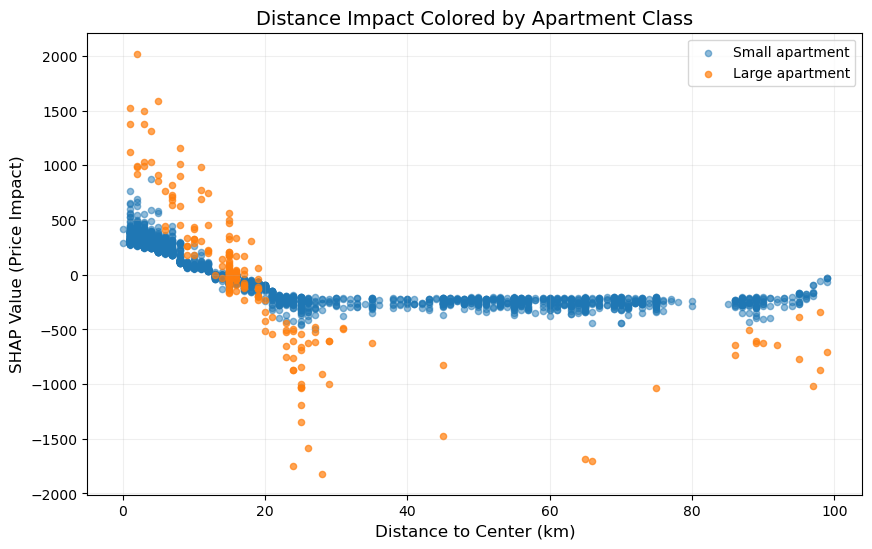

In [ ]:
age_mask = X_train['building_age'] < 100
filtered_features = X_train[age_mask]
filtered_shap_values = shap_values_train[age_mask]

age_values = filtered_features['building_age'].values
shap_values = filtered_shap_values[:, selected_features.get_loc('building_age')]
area_mask = filtered_features['area'].ge(100)
plt.figure(figsize=(10, 6))

plt.scatter(
    age_values[~area_mask],
    shap_values[~area_mask],
    c='#1f77b4',
    s=20,
    alpha=0.5,
    label='Small apartment'
)

plt.scatter(
    age_values[area_mask],
    shap_values[area_mask],
    c='#ff7f0e',
    s=20,
    alpha=0.7,
    label='Large apartment'
)

plt.xlabel("Distance to Center (km)", fontsize=12)
plt.ylabel("SHAP Value (Price Impact)", fontsize=12)
plt.title("Distance Impact Colored by Apartment Class", fontsize=14)
plt.legend()
plt.grid(alpha=0.2)
plt.show()

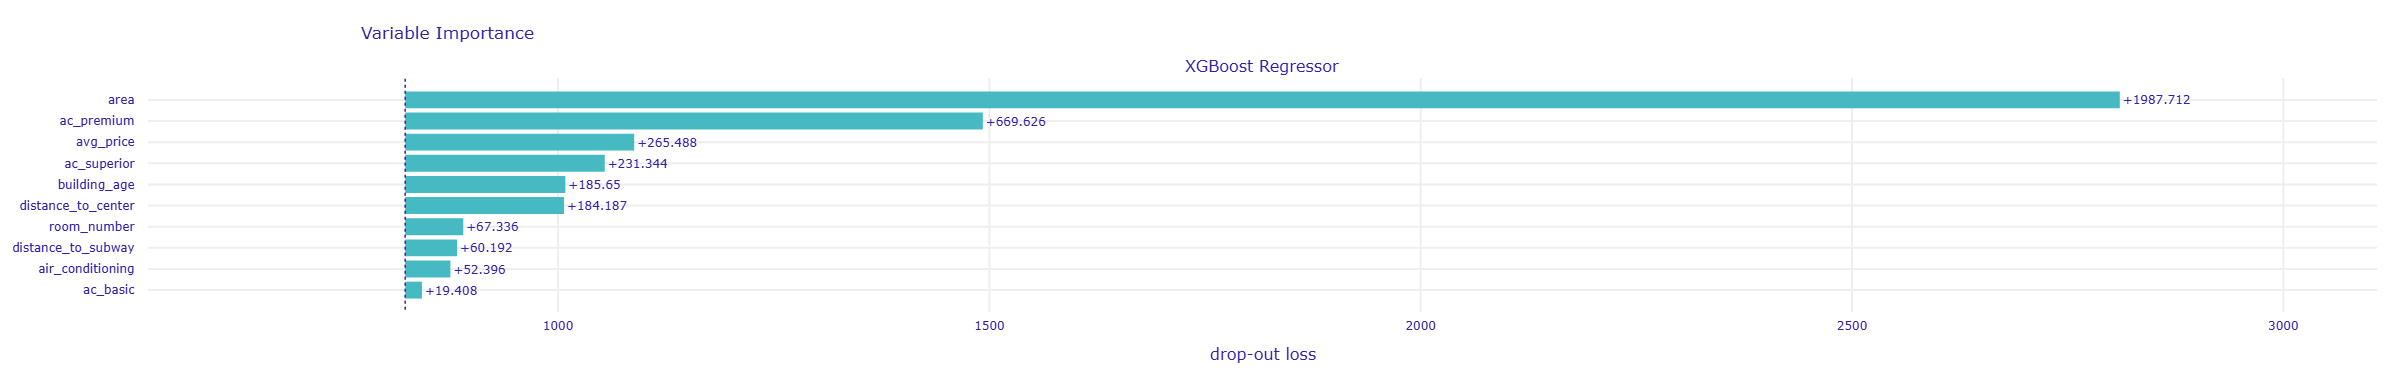

In [220]:
explainer.model_parts().plot()

In [128]:
aspects = {'space': ['area', 'room_number'],
           'layout': ['terrace', 'separate_kitchen', 'utility_room'],
           'construction': ['building_age', 'bt_tenement'],
           'spatial': ['distance_to_center', 'distance_to_subway', 'avg_price'],
           'district': ['Targowek', 'Wilanow'],
           'class': ['ac_premium', 'ac_superior', 'ac_basic']}

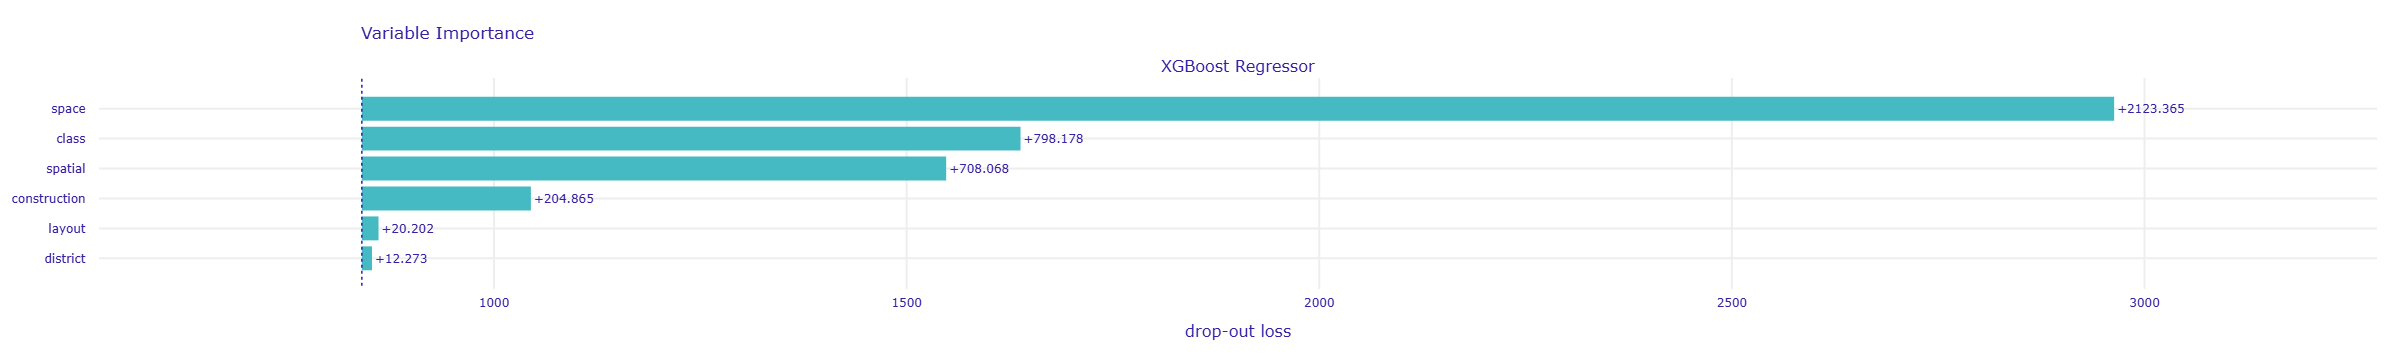

In [136]:
explainer.model_parts(variable_groups=aspects).plot()

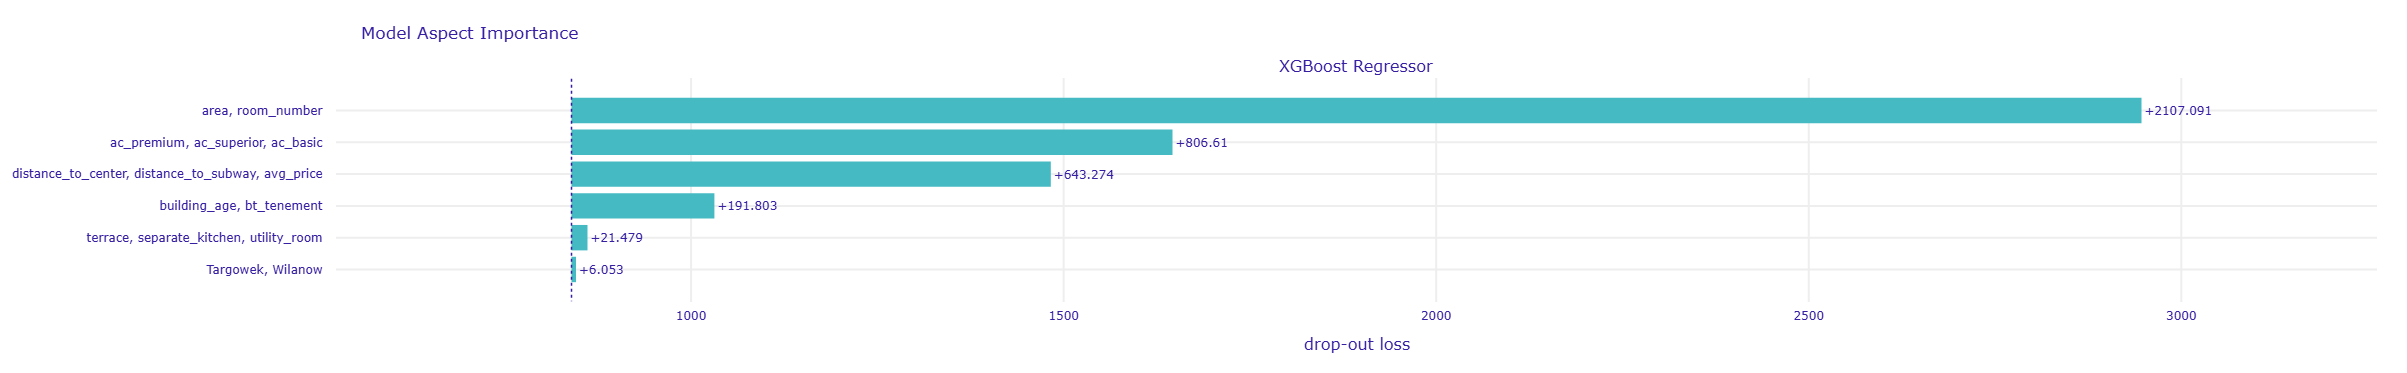

In [130]:
asp.model_parts(variable_groups=aspects).plot()

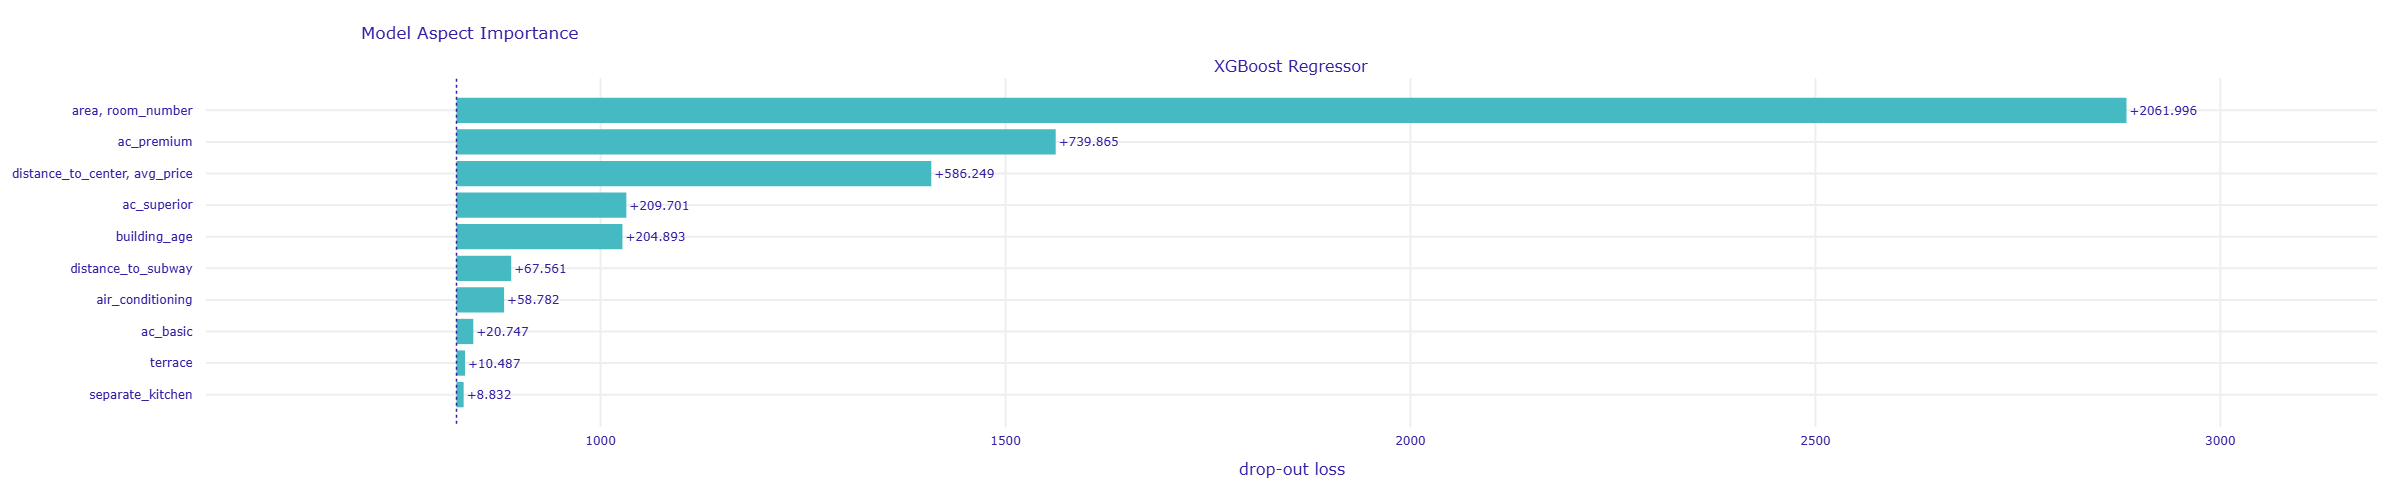

In [118]:
asp.model_parts().plot()

__SHAP Tree Explainer - Train Sample__

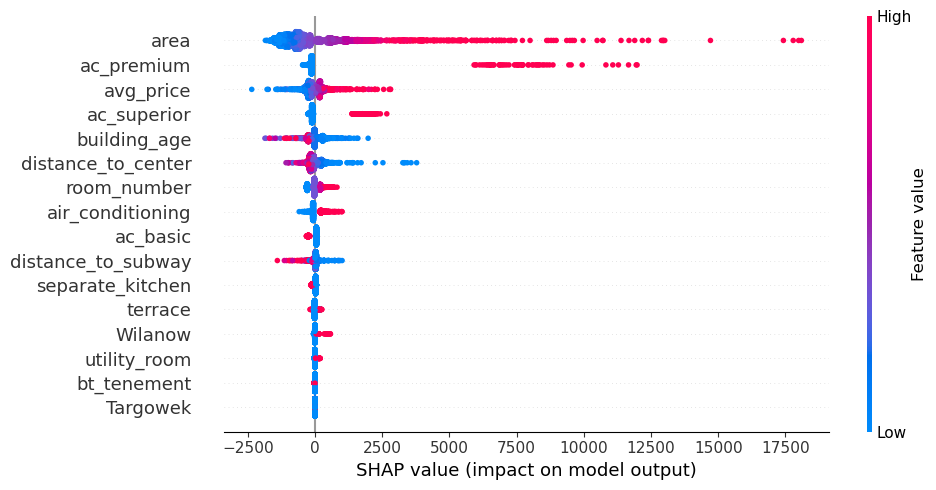

In [278]:
shap_explainer = shap.TreeExplainer(best_model)

shap_values_train = shap_explainer.shap_values(X_train[selected_features])
shap.summary_plot(shap_values_train, X_train[selected_features], plot_size=(10, 5))

In [306]:
shap_explainer = shap.TreeExplainer(best_model)
shap_values_train = shap_explainer.shap_values(X_train[selected_features])

apartment_classes = ['ac_basic', 'ac_superior', 'ac_premium']
results = []
for ac in apartment_classes:
    ac_idx = selected_features.get_loc(ac)
    ac_shap = shap_values_train[:, ac_idx]
    
    central_mask = X_train.distance_to_center.le(1)&X_train[ac].eq(1)
    non_central_mask = X_train.distance_to_center.gt(1)&X_train[ac].eq(1)
    central_shap = ac_shap[central_mask]
    non_central_shap = ac_shap[non_central_mask]
    
    results.append({
        'class': ac.replace('ac_', ''),
        'central_median_effect': np.median(central_shap),
        'non_central_median_effect': np.median(non_central_shap),
        'effect_ratio': np.median(central_shap) / np.median(non_central_shap),
        'p_value (Mann-Whitney U test)': stats.mannwhitneyu(central_shap, non_central_shap, alternative='two-sided').pvalue
    })

result_df = pd.DataFrame(results).set_index('class')
print("Apartment Class - Price Impact Comparison:")
result_df.reset_index()

Apartment Class - Price Impact Comparison:


,class,central_median_effect,non_central_median_effect,effect_ratio,p_value (Mann-Whitney U test)
0,basic,-289.975769,-250.375000,1.158166,6.061737e-12
1,superior,2142.194092,1750.057007,1.224071,1.741348e-07
2,premium,7719.238281,6965.533691,1.108205,5.290291e-04


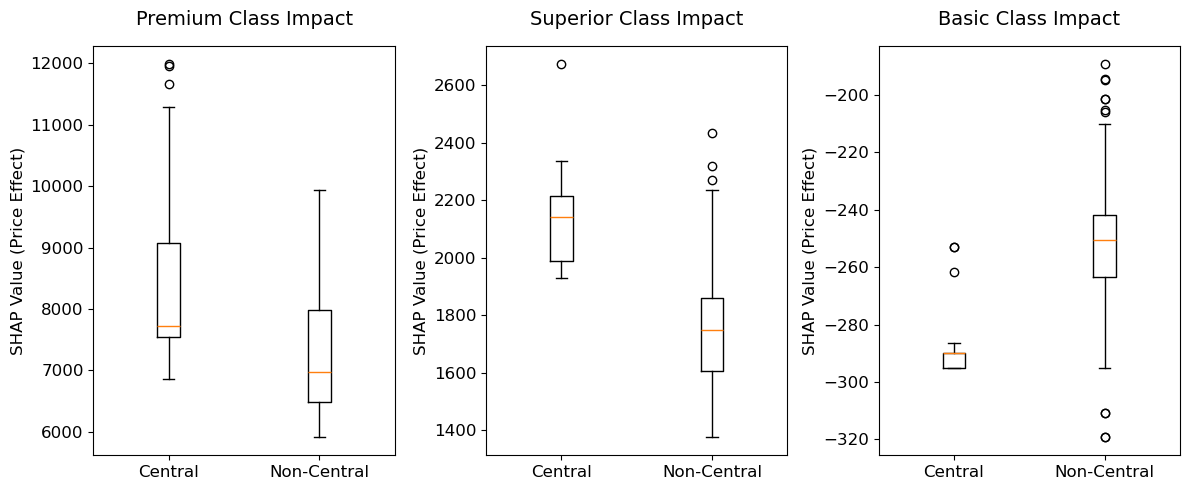

In [298]:
plt.figure(figsize=(12, 5))

for i, ac in enumerate(['ac_premium', 'ac_superior', 'ac_basic']):
    ac_idx = selected_features.get_loc(ac)
    plt.subplot(1, 3, i+1)
    
    central_mask = X_train.distance_to_center.le(1) & X_train[ac].eq(1)
    non_central_mask = X_train.distance_to_center.gt(1) & X_train[ac].eq(1)
    
    plt.boxplot([
        shap_values_train[central_mask, ac_idx],
        shap_values_train[non_central_mask, ac_idx]
    ], labels=['Central', 'Non-Central'])
    
    plt.title(f"{ac.replace('ac_', '').title()} Class Impact", fontsize=14, pad=15)
    plt.ylabel('SHAP Value (Price Effect)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

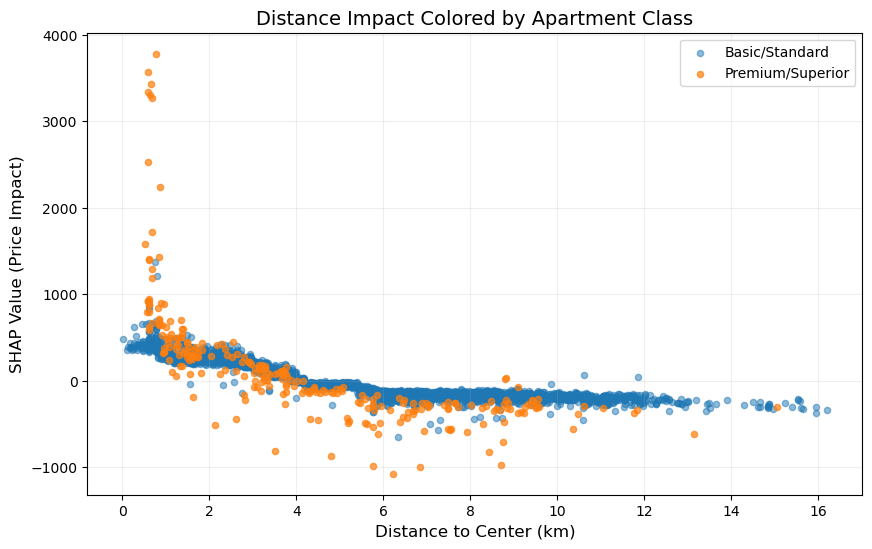

In [342]:
distance_values = X_train['distance_to_center'].values
shap_values = shap_values_train[:, selected_features.get_loc('distance_to_center')]
premium_mask = (X_train['ac_premium'] == 1) | (X_train['ac_superior'] == 1)
plt.figure(figsize=(10, 6))

# Plot non-premium points
plt.scatter(
    distance_values[~premium_mask],
    shap_values[~premium_mask],
    c='#1f77b4',
    s=20,
    alpha=0.5,
    label='Basic/Standard'
)

# Plot premium/superior points
plt.scatter(
    distance_values[premium_mask],
    shap_values[premium_mask],
    c='#ff7f0e',
    s=20,
    alpha=0.7,
    label='Premium/Superior'
)

plt.xlabel("Distance to Center (km)", fontsize=12)
plt.ylabel("SHAP Value (Price Impact)", fontsize=12)
plt.title("Distance Impact Colored by Apartment Class", fontsize=14)
plt.legend()
plt.grid(alpha=0.2)
plt.show()

__SHAP Tree Explainer - Out of time__

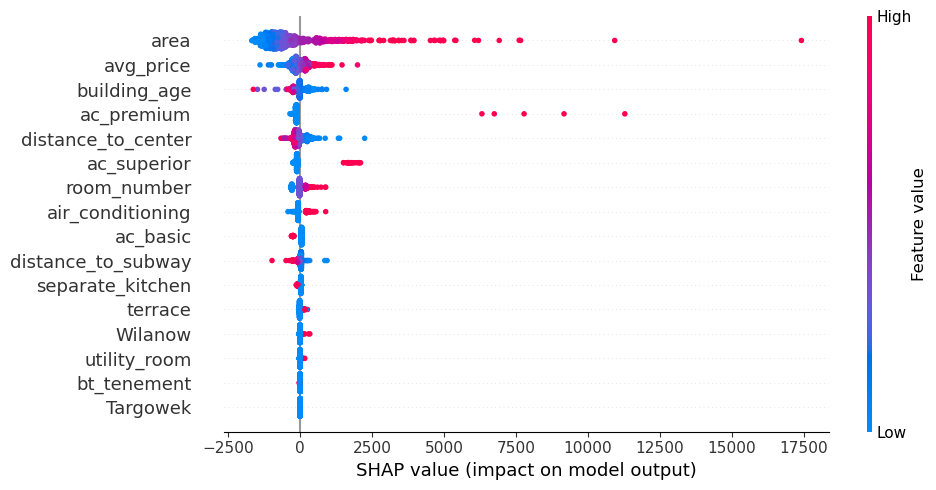

In [47]:
shap_values_oot = shap_explainer.shap_values(X_out_of_time[selected_features])
shap.summary_plot(shap_values_oot, X_out_of_time[selected_features], plot_size=(10, 5))

In [ ]:
shap.summary_plot(shap_values_train, X_train[selected_features], plot_size=(10, 5))

In [73]:
check_features = [i for i in selected_features if not i.startswith('ac')] 

In [ ]:
# Get indices of features to include
valid_feature_indices = [filtered_features.columns.get_loc(f) 
                       for f in check_features 
                       if f in filtered_features.columns]

# Subset SHAP values and features
filtered_shap_subset = filtered_shap[:, valid_feature_indices]
filtered_features_subset = filtered_features[features_to_include]

In [113]:
[filtered_features.columns.get_loc(f) 
                         for f in check_features 
                         if f in filtered_features.columns]

array([[-1011.9998   ,   -18.36456  ,   -15.568815 , ...,  -117.223335 ,
            0.       ,    -3.3539236],
       [ -203.06096  ,   -30.116123 ,   -10.666222 , ...,  -101.77118  ,
            0.       ,    -4.8872886],
       [ -943.5585   ,  -269.9006   ,    -8.143814 , ...,  -104.60788  ,
            0.       ,    -4.7093873],
       ...,
       [ -478.6424   ,    -9.046589 ,    -9.16396  , ...,  -100.019745 ,
            0.       ,    -4.6473846],
       [ -636.76526  ,   -36.931763 ,   -10.103043 , ...,  -113.332344 ,
            0.       ,    -4.7491245],
       [ -799.4021   ,   -17.732777 ,    -7.734897 , ...,   -99.20985  ,
            0.       ,    -4.6885967]], dtype=float32)

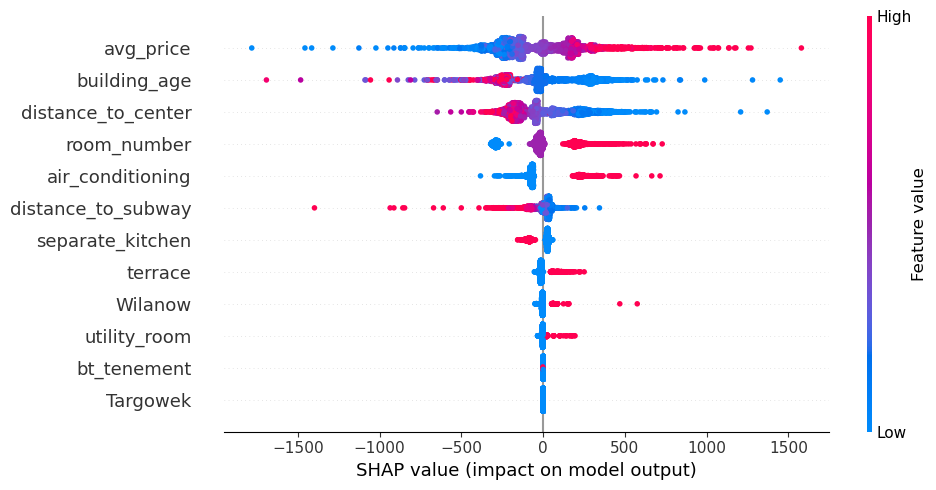

In [129]:
check_features = [i for i in selected_features if not i.startswith('ac') and  i != 'area'] 
shap_values_train = shap_explainer.shap_values(X_train[selected_features])

mask = (X_train.ac_standard.eq(1)|X_train.ac_basic.eq(1)).to_list()
filtered_shap = shap_values_train[mask]
filtered_features = X_train[selected_features].iloc[mask]
valid_feature_indices = [filtered_features.columns.get_loc(f) 
                         for f in check_features 
                         if f in filtered_features.columns]
filtered_shap_subset = filtered_shap[:, valid_feature_indices]
filtered_features_subset = filtered_features[check_features]
shap.summary_plot(filtered_shap_subset, filtered_features_subset, plot_size=(10, 5))

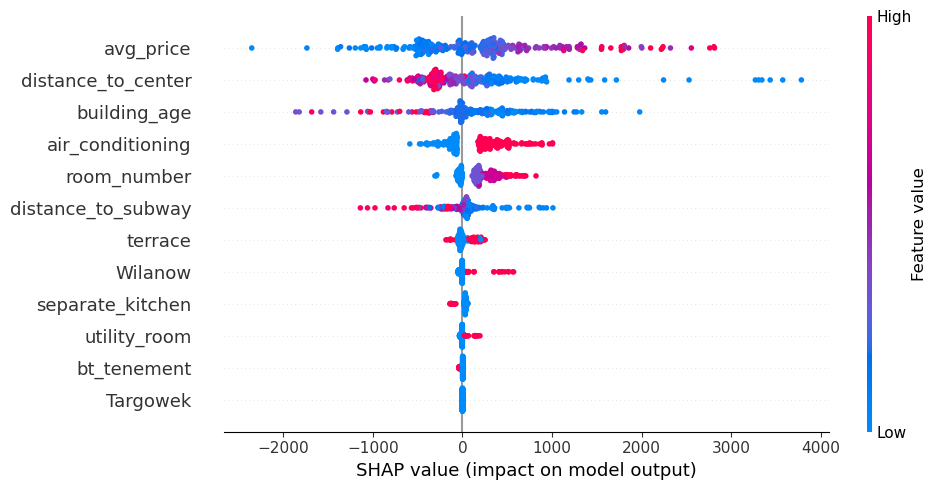

In [131]:
mask = (X_train.ac_superior.eq(1)|X_train.ac_premium.eq(1)).to_list()
filtered_shap = shap_values_train[mask]
filtered_features = X_train[selected_features].iloc[mask]
valid_feature_indices = [filtered_features.columns.get_loc(f) 
                         for f in check_features 
                         if f in filtered_features.columns]
filtered_shap_subset = filtered_shap[:, valid_feature_indices]
filtered_features_subset = filtered_features[check_features]
shap.summary_plot(filtered_shap_subset, filtered_features_subset, plot_size=(10, 5))

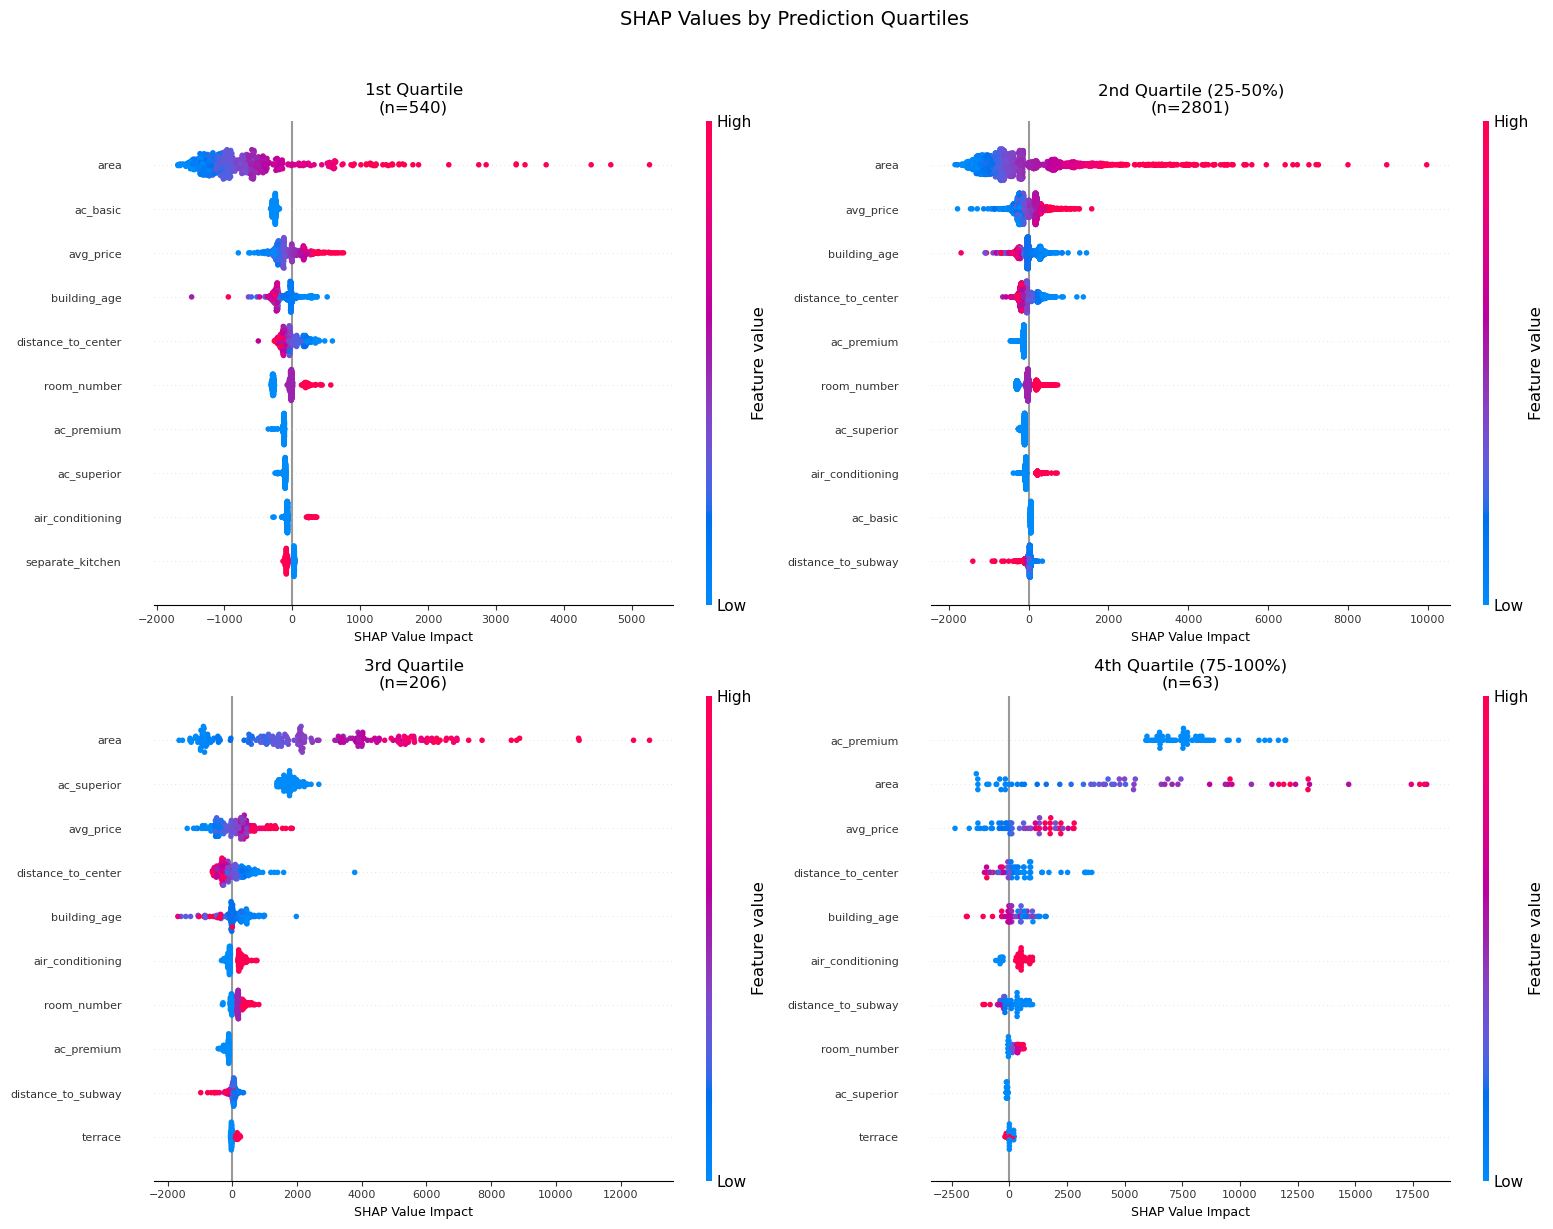

In [77]:
quantiles = np.quantile(y_pred_train, [0.25, 0.5, 0.75])

# Create masks for each quartile
masks = [
    X_train.ac_basic.eq(1).to_list(),  # 1st quartile
    X_train.ac_standard.eq(1).to_list(),  # 2nd quartile
    X_train.ac_superior.eq(1).to_list(),  # 3rd quartile
    X_train.ac_premium.eq(1).to_list(),  # 4th quartile
]

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
quartile_names = ['1st Quartile', '2nd Quartile (25-50%)',
                  '3rd Quartile', '4th Quartile (75-100%)']



# Create plots for each quartile
for i, (mask, name) in enumerate(zip(masks, quartile_names)):
    ax = axes[i//2, i%2]
    
    # Filter data for current quartile
    filtered_shap = shap_values_train[mask]
    filtered_features = X_train[selected_features].iloc[mask]
    
    # Create SHAP plot using matplotlib context
    plt.sca(ax)  # Set current axis
    shap.summary_plot(
        filtered_shap,
        filtered_features,
        show=False,
        plot_size=None,
        max_display=10
    )
    
    # Customize subplot
    ax.set_title(f"{name}\n(n={len(filtered_features)})", fontsize=12)
    ax.set_xlabel("SHAP Value Impact", fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.suptitle("SHAP Values by Prediction Quartiles", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

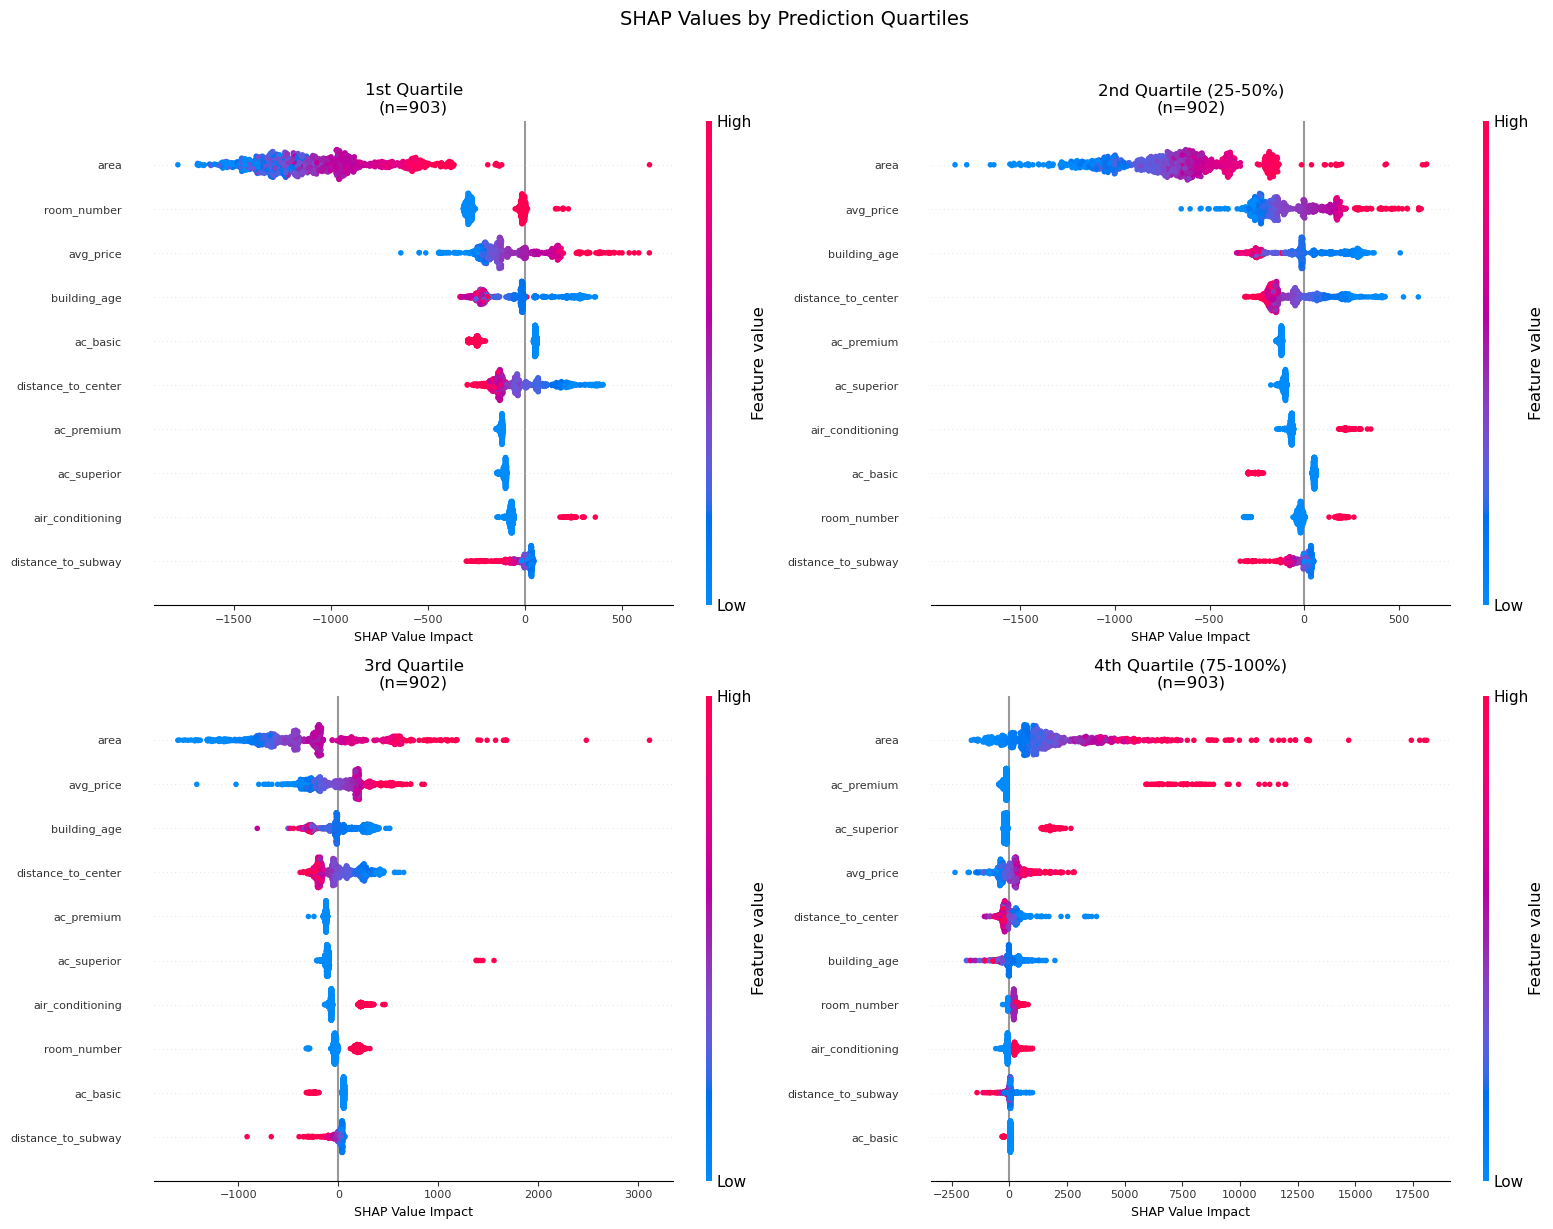

In [53]:
quantiles = np.quantile(y_pred_train, [0.25, 0.5, 0.75])

# Create masks for each quartile
masks = [
    (y_pred_train <= quantiles[0]),  # 1st quartile
    (y_pred_train > quantiles[0]) & (y_pred_train <= quantiles[1]),  # 2nd quartile
    (y_pred_train > quantiles[1]) & (y_pred_train <= quantiles[2]),  # 3rd quartile
    (y_pred_train > quantiles[2])  # 4th quartile
]

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
quartile_names = ['1st Quartile', '2nd Quartile (25-50%)',
                  '3rd Quartile', '4th Quartile (75-100%)']

# Create plots for each quartile
for i, (mask, name) in enumerate(zip(masks, quartile_names)):
    ax = axes[i//2, i%2]
    
    # Filter data for current quartile
    filtered_shap = shap_values_train[mask]
    filtered_features = X_train[selected_features].iloc[mask]
    
    # Create SHAP plot using matplotlib context
    plt.sca(ax)  # Set current axis
    shap.summary_plot(
        filtered_shap,
        filtered_features,
        show=False,
        plot_size=None,
        max_display=10
    )
    
    # Customize subplot
    ax.set_title(f"{name}\n(n={len(filtered_features)})", fontsize=12)
    ax.set_xlabel("SHAP Value Impact", fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.suptitle("SHAP Values by Prediction Quartiles", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

__Ceteris Paribus plots - Train Sample__

Preparation of a new explainer is initiated

  -> data              : 3610 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3610 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGBoost Model
  -> predict function  : <function yhat_default at 0x000001EF223E3C40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.24e+03, mean = 5.07e+03, max = 4.52e+04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.33e+03, mean = -0.146, max = 7.44e+03
  -> model_info        : package xgboost

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 6/6 [00:00<00:00, 205.17it/s]


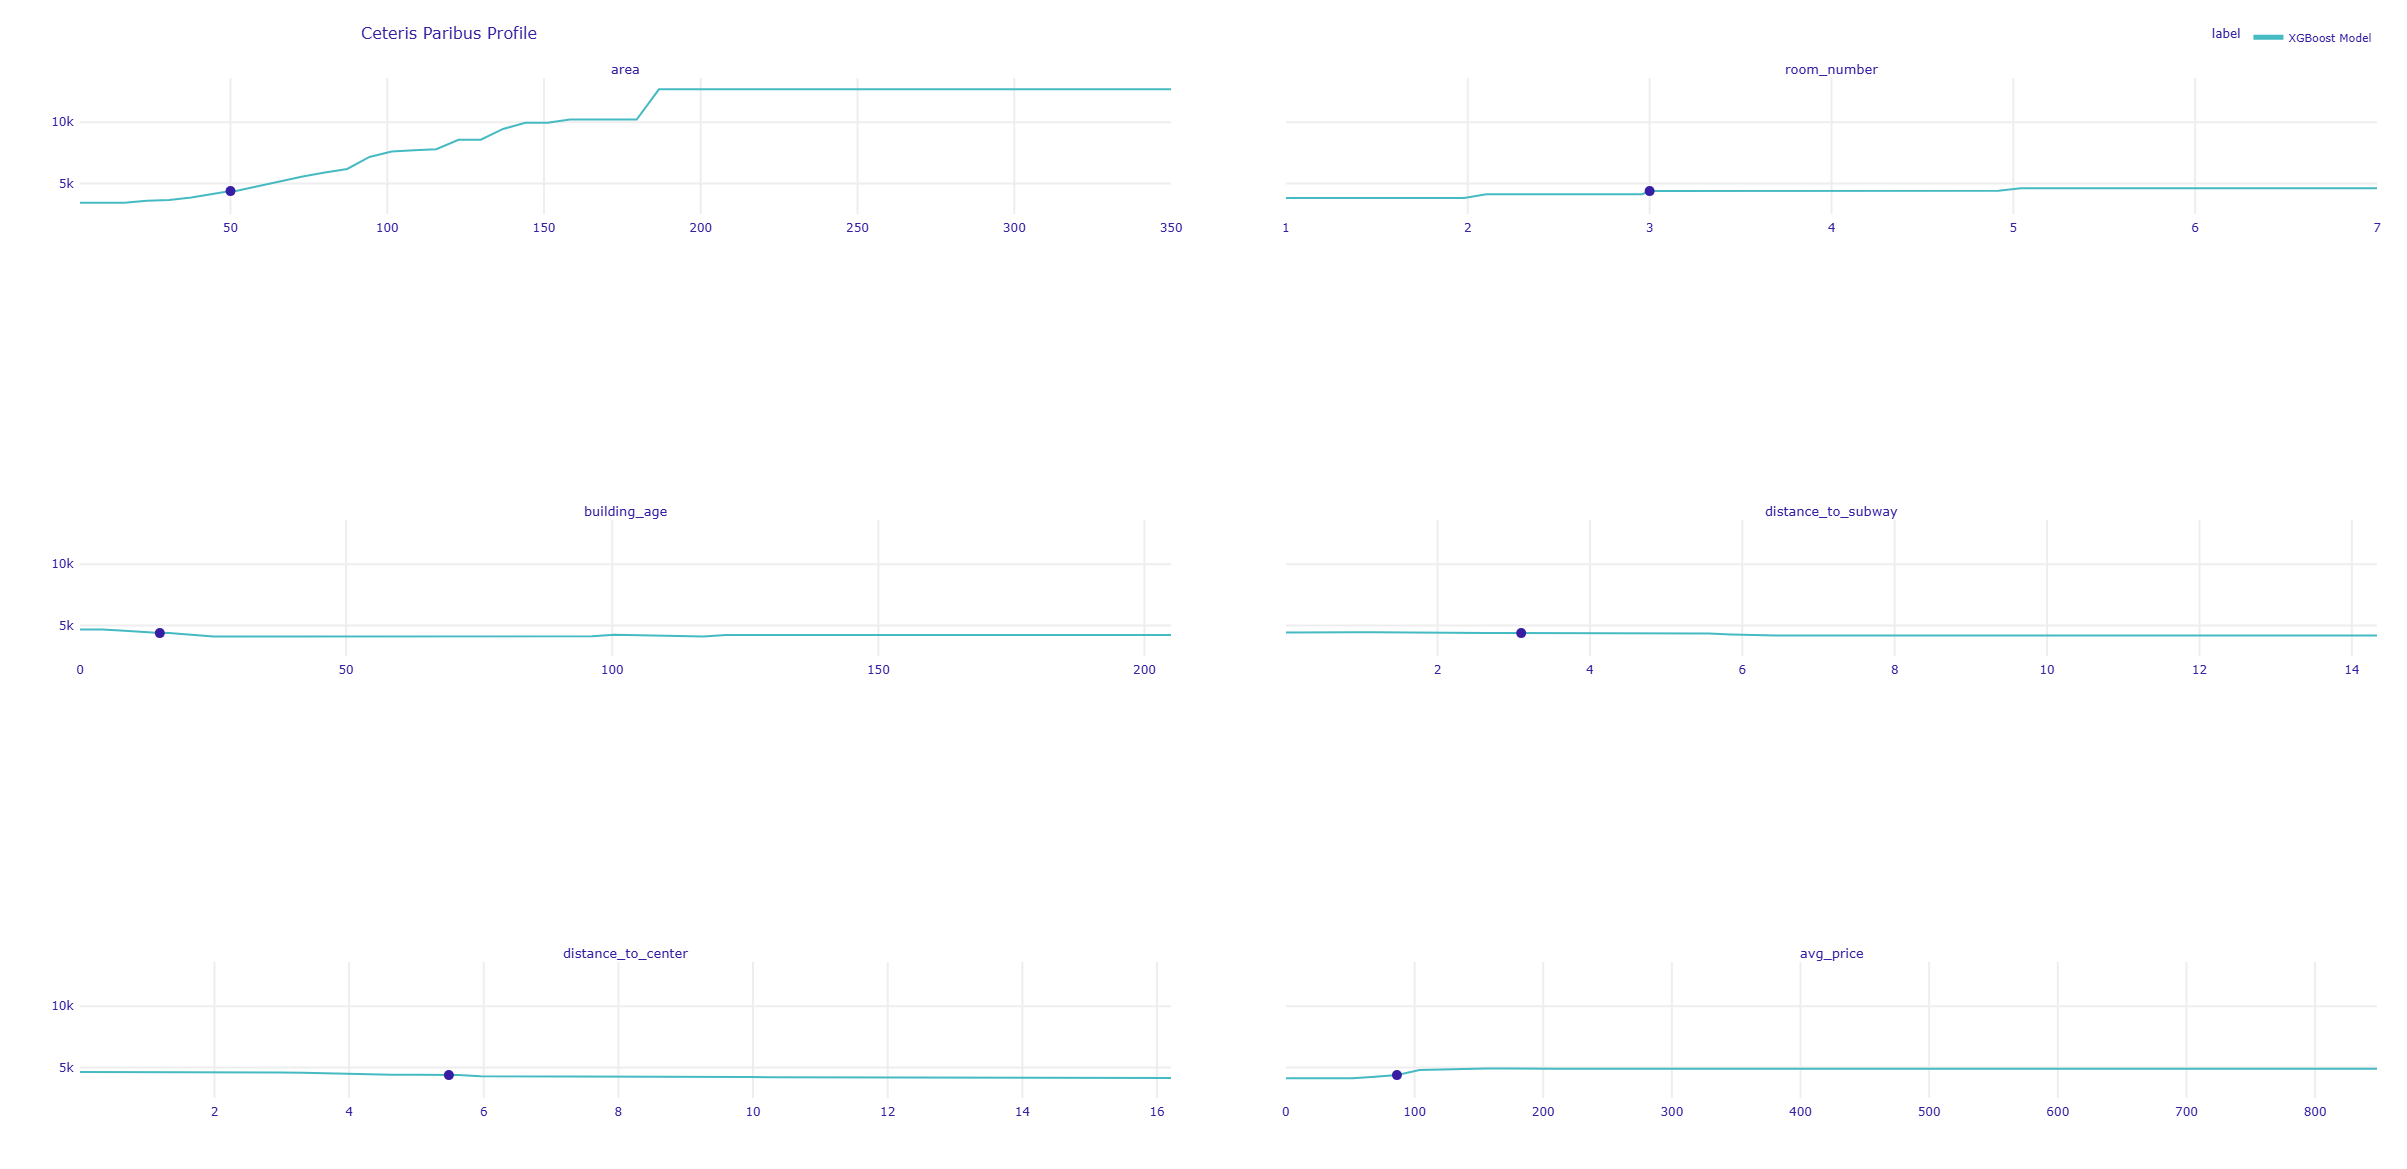

In [163]:
variables = ['area', 'room_number', 'building_age', 'distance_to_subway', 'distance_to_center', 'avg_price']
# 1. Create explainer
explainer = dx.Explainer(
    best_model,  # your trained model
    X_train[selected_features],  # your features
    y_train,  # your target
    label="XGBoost Model"  # optional label
)

# 2. Select observation(s) to analyze
selected_observation = X_train[selected_features].iloc[[150]]  # First observation

# 3. Create ceteris paribus profile
cp_profile = explainer.predict_profile(
    selected_observation,
    variables=variables,  
    grid_points=50  # number of points in grid
)

# 4. Plot the results
cp_profile.plot(
    variables=None,  # None for all variables, or list of specific ones
    title="Ceteris Paribus Profile",
    vertical_spacing=0.3,
    show=False
)